In [1]:
import numpy as np
from Beta_optimization import alternating_beta_projection
from KL_optimization import alternating_kl_projection
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

In [2]:
def kl_divergence(p, q):
    """
    Compute the KL divergence between p and empirical distribution
    
    Parameters:
        p: distribution, array_like
        beta: distribution, array_like, same dimensions as p
    
    Returns:
        KL divergence between p and q, scalar
    """
    return np.sum(p * np.log((p) / (q)))

In [3]:
def sample_empirical(true_pi, num_samples):
    """
    Construct the empirical distribution from the sample from discrete distribution 
    
    Parameters:
        true_pi: distribution, array_like
        num_samples: sample size, scalar
    
    Returns:
        empirical distribution, array_like, same dimensions as true_pi
        
    """
    # Flatten the true distribution
    flat_probs = true_pi.flatten()
    
    # Generation of empirical distribution from the true distribution
    picks = np.random.choice(len(flat_probs), size=num_samples, p=flat_probs)
    emp   = np.zeros_like(flat_probs)
    uniq, cnts = np.unique(picks, return_counts=True)
    emp[uniq] = cnts / num_samples
    
    # Reshape back to the original shape
    return emp.reshape(true_pi.shape)

Modifying the dataset

In [4]:
# Get the notebook’s directory
notebook_dir = Path().resolve()

# Get path to CSV file
csv_path = notebook_dir / "indiv_rw_2021.csv"

# Load data
df = pd.read_csv(csv_path)

In [5]:
#Preparing data
# Age categorization
def categorize_age(age):
    if 15 <= age <= 23:
        return 1
    elif 24 <= age <= 64:
        return 2
    else:
        return -1

# Create the new column 'age_reduced'
df['age_reduced'] = df['age'].apply(categorize_age)

# Filter the original DataFrame based on the condition that age_reduced is 1, 2, and employment is not 4
filtered_df = df[(df['age_reduced'].isin([1, 2])) & (df['employment'] != 4)][['age_reduced', 'gender', 'employment']]

In [6]:
# Get the counts of each combination
joint_counts_reduced = (
    filtered_df
    .groupby(['age_reduced', 'gender', 'employment'])
    .size()
    .reset_index(name='count')
)

print(joint_counts_reduced)    

    age_reduced  gender  employment  count
0             1       1           1   1529
1             1       1           2    238
2             1       1           3    796
3             1       2           1   1524
4             1       2           2    214
5             1       2           3    871
6             2       1           1  14798
7             2       1           2   1245
8             2       1           3    156
9             2       2           1  13236
10            2       2           2   2527
11            2       2           3    135


In [7]:
# Create tensor object with counts
# Determine dimensions based on the max category values
I = filtered_df['age_reduced'].max()
J = filtered_df['gender'].max()
K = filtered_df['employment'].max()

# Create and populate the 3D tensor
tensor = np.zeros((I, J, K), dtype=int)
for _, row in joint_counts_reduced.iterrows():
    i, j, k = int(row['age_reduced']) - 1, int(row['gender']) - 1, int(row['employment']) - 1
    tensor[i, j, k] = row['count']

In [8]:
# Normalize tensor to get true data generating process
true_pdf = tensor / tensor.sum()
print(true_pdf)

[[[0.04102605 0.006386   0.02135823]
  [0.04089189 0.00574204 0.02337063]]

 [[0.39705922 0.03340578 0.00418578]
  [0.35514771 0.06780434 0.00362231]]]


In [9]:
# Calculate the marginals based on the normalized true_pdf
marginal_age = np.sum(true_pdf, axis=(1, 2))  # Sum over gender and employment 
marginal_gender = np.sum(true_pdf, axis=(0, 2))        # Sum over age and employment 
marginal_employment = np.sum(true_pdf, axis=(0, 1))     # Sum over age and gender 

Assign the parameters of simulation

In [10]:
target_trials = 1000
num_samples   = 200

# epsilon grid
eps_range = np.linspace(0.001, 0.0001, num=10)

In [11]:
# Define the list of β values
beta_list = [1.05]

# Stats for all projections
stats = {
    #  Stats for KL 
    'avg_values_kl':        [],                
    'kl_divergence_kl':     [], 
    # Stats for Beta for each beta in list
    'avg_values_beta':      {b: [] for b in beta_list},
    'kl_divergence_beta':   {b: [] for b in beta_list},
}


for eps in eps_range:
    # Output for KL
    zero_vals_kl       = []
    kl_vals_kl         = []
    # Output for Beta
    zero_vals_beta     = {b: [] for b in beta_list}
    kl_vals_beta       = {b: [] for b in beta_list}

    for _ in range(target_trials):
        # Generation of empirical distribution from the sample
        pi_hat = sample_empirical(true_pdf, num_samples)
        
        # Locate zeros in the empirical distribution
        zero_idx = np.where(pi_hat == 0)

        # KL projection
        proj_kl = alternating_kl_projection(
            pi_hat,
            marginals=[marginal_age, marginal_gender, marginal_employment],
            num_iters=100,
            replace_zeros=True,
            epsilon=eps
        )
        for idx in zip(*zero_idx):
            zero_vals_kl.append(proj_kl[idx])
        kl_vals_kl.append(kl_divergence(proj_kl, true_pdf))

        # Beta projections for each beta in list
        for b in beta_list:
            proj_bt = alternating_beta_projection(
                pi_hat,
                marginals=[marginal_age, marginal_gender, marginal_employment],
                beta=b,
                num_iters=1,
                full_cycles=50,
                replace_zeros=True,
                epsilon=eps
            )
            for idx in zip(*zero_idx):
                zero_vals_beta[b].append(proj_bt[idx])
            kl_vals_beta[b].append(kl_divergence(proj_bt, true_pdf))

    # Update KL stats
    stats['avg_values_kl'].append(np.mean(zero_vals_kl))
    stats['kl_divergence_kl'].append(np.mean(kl_vals_kl))

   # Update Beta stats
    for b in beta_list:
        stats['avg_values_beta'][b].append(np.mean(zero_vals_beta[b]))
        stats['kl_divergence_beta'][b].append(np.mean(kl_vals_beta[b]))

    # Print stats for each iteration
    summary = (
        f"eps={eps:.4f} | "
        f"KL: avg0={stats['avg_values_kl'][-1]:.6f}, "
        f"KL-div={stats['kl_divergence_kl'][-1]:.6f}"
    )
    for b in beta_list:
        summary += (
            f" || β={b}: "
            f"avg0={stats['avg_values_beta'][b][-1]:.6f}, "
            f"KL-div={stats['kl_divergence_beta'][b][-1]:.6f}"
        )
    print(summary)


eps=0.0010 | KL: avg0=0.001221, KL-div=0.016491 || β=1.05: avg0=0.001268, KL-div=0.016440
eps=0.0009 | KL: avg0=0.001112, KL-div=0.016697 || β=1.05: avg0=0.001161, KL-div=0.016618
eps=0.0008 | KL: avg0=0.000977, KL-div=0.017036 || β=1.05: avg0=0.001021, KL-div=0.016987
eps=0.0007 | KL: avg0=0.000875, KL-div=0.017096 || β=1.05: avg0=0.000920, KL-div=0.017017
eps=0.0006 | KL: avg0=0.000778, KL-div=0.017748 || β=1.05: avg0=0.000826, KL-div=0.017652
eps=0.0005 | KL: avg0=0.000633, KL-div=0.017871 || β=1.05: avg0=0.000673, KL-div=0.017781
eps=0.0004 | KL: avg0=0.000507, KL-div=0.018785 || β=1.05: avg0=0.000541, KL-div=0.018704
eps=0.0003 | KL: avg0=0.000370, KL-div=0.018701 || β=1.05: avg0=0.000395, KL-div=0.018634
eps=0.0002 | KL: avg0=0.000271, KL-div=0.019519 || β=1.05: avg0=0.000300, KL-div=0.019411
eps=0.0001 | KL: avg0=0.000128, KL-div=0.019741 || β=1.05: avg0=0.000141, KL-div=0.019695


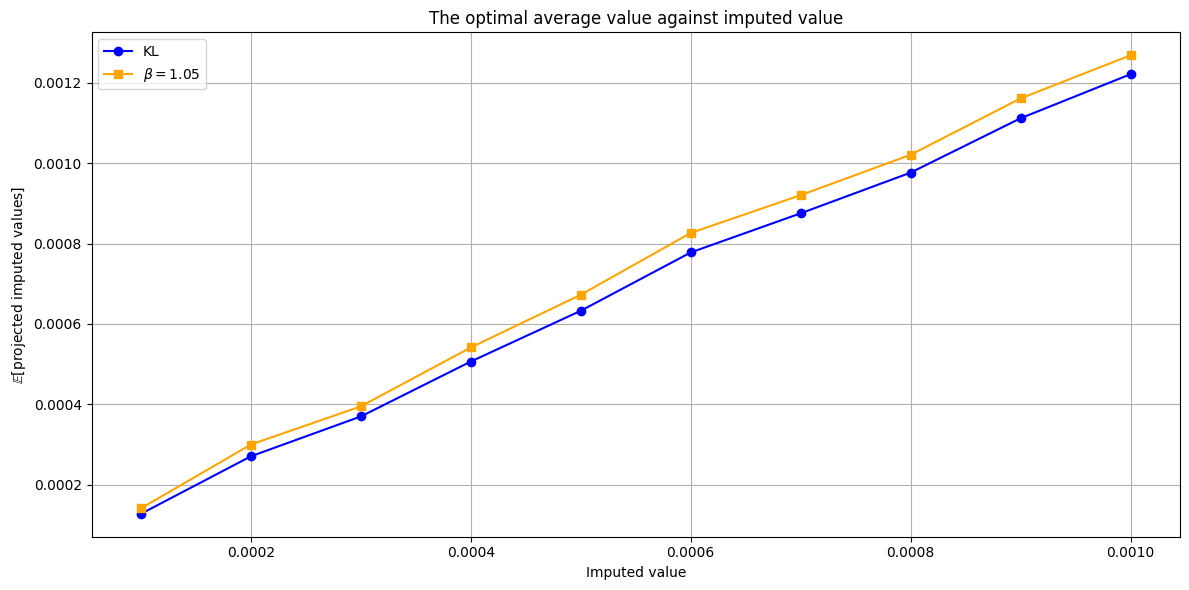

In [12]:
# Mean projected values for imputed values and save in current directory
plt.figure(figsize=(12, 6))
plt.plot(
    eps_range,
    stats['avg_values_kl'],
    marker='o',
    label='KL',
    color='blue'
)
b = beta_list[0]
plt.plot(
    eps_range,
    stats['avg_values_beta'][b],
    marker='s',
    label=rf'$\beta={b}$',
    color='orange'
)
plt.xlabel('Imputed value')
plt.ylabel(r'$\mathbb{E}[\text{projected imputed values}]$')
plt.title('The optimal average value against imputed value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('optimal_exp_vs_imp_real_data_low.png')
plt.show()




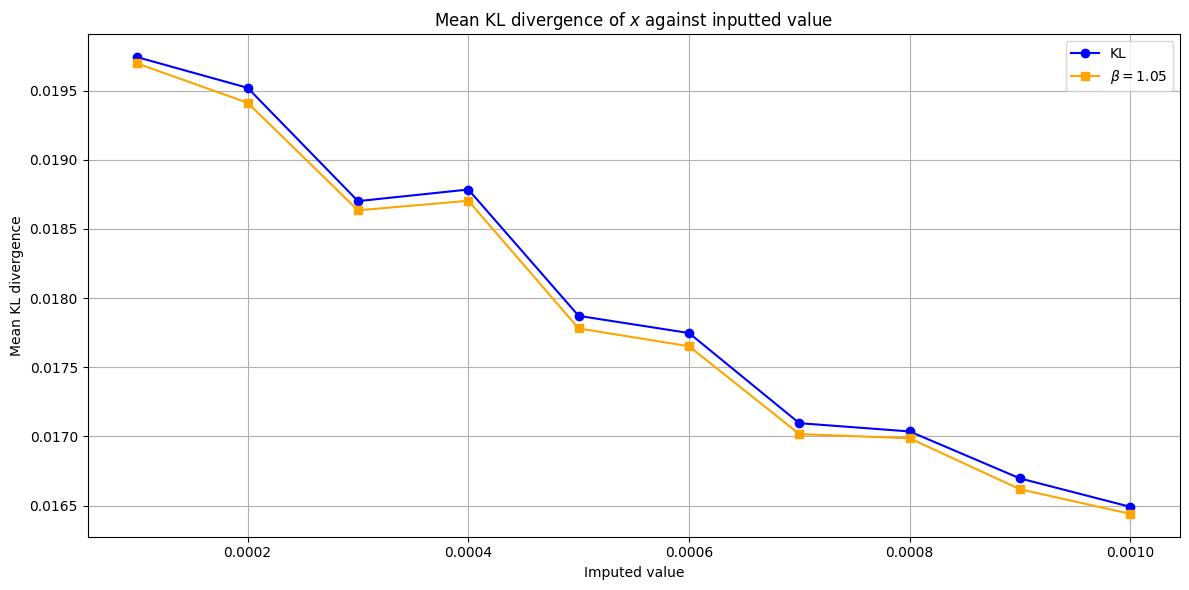

In [13]:
# Mean KL divergence comparison and save in current directory
plt.figure(figsize=(12, 6))
plt.plot(
    eps_range,
    stats['kl_divergence_kl'],
    marker='o',
    label='KL',
    color='blue'
)
b = beta_list[0]
plt.plot(
    eps_range,
    stats['kl_divergence_beta'][b],
    marker='s',
    label=rf'$\beta={b}$',
    color='orange'
)
plt.xlabel('Imputed value')
plt.ylabel('Mean KL divergence')
plt.title(r'Mean KL divergence of $x$ against inputted value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('mean_KL_vs_imp_real_data_low.png')
plt.show()
